In [ ]:
# !pip install fastai

In [93]:
# auto-updating
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Setting Random Seed and Using CUDA for GPU Processing

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import glob
from sklearn.preprocessing import LabelEncoder
import os
import torch
import fastai
import time
from fastai.vision import *
np.random.seed(0) 
from torchvision.models import resnet50
from torchvision.models import mobilenet_v2
from torchvision.models import vgg16
from fastai.callbacks import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from fastai import *
# from fastai.dataset import ModelData,ArraysIndexDataset
# from fastai.dataloader import DataLoader
# from fastai.learner import Learner

import torch
import torch.nn as nn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def random_seed(seed_value, use_cuda):  
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    random.seed(seed_value) 
    torch.backends.cudnn.deterministic = True

    if use_cuda: torch.cuda.manual_seed_all(seed_value) 

# Set seed
#random_seed(0,False)
random_seed(0,True)

In [95]:
#from fastai.callbacks import CSVLogger

In [96]:
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA_LAUNCH_BLOCKING=1

CUDA Available? True


In [97]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

In [ ]:
# Set batch size of images 
bs = 4
 #32  #64

image_path = Path(r"C:\Users\Desktop\Augmented_Images")

image_path.ls()

In [ ]:
## load data
# fastai is automatically supposed to handle image format conversions- greyscale(L), RGB

# https://forums.fast.ai/t/how-to-load-images-as-grayscale/36895/6
# google: can fastai convert greyscale images to RGB

data = ImageDataBunch.from_folder(image_path, 
                                  valid_pct=0.4,
                                  ds_tfms=get_transforms(), 
                                  size=512, 
                                  bs=bs, 
                                  num_workers=1,
                                  seed=9).normalize(imagenet_stats)

In [101]:
data.classes
data.c
len(data.train_ds)
len(data.valid_ds)

['Good', 'Grind', 'Induction', 'Stain']

4

167

110

In [102]:
# count no. of examples in train & validation sets 
# train set
vc = pd.value_counts(data.train_ds.y.items, sort =False)
vc.index = data.classes
vc
# ratio

Good         101
Grind         12
Induction     39
Stain         15
dtype: int64

In [103]:
# val set
vc = pd.value_counts(data.valid_ds.y.items, sort =False)
# vc.index = data.classes
vc
# ratio

0    79
1     3
2    19
3     9
dtype: int64

In [ ]:
data.show_batch(rows=3, figsize=(7,8))
#data.show_batch(rows=3, figsize=(10,10), ds_type=DatasetType.Valid)
#data.show_batch(rows=3, figsize=(10,10), ds_type=DatasetType.Train)

In [105]:
precision = Precision()
recall = Recall()
metrics = [accuracy,precision,recall]

# With Class Weights

In [16]:
import os
Data_Path=r"C:\Users\Desktop\Augmented_Images"
files=os.listdir(Data_Path)
Class_weights=[]
for f in files:
    length_files=len(os.listdir(os.path.join(Data_Path,f)))
    print(length_files)
    weights=1/length_files
    Class_weights.append(weights)
class_weights=torch.FloatTensor(Class_weights).cuda()

In [243]:
#callback_fn=partial(CSVLogger, filename=f'sample_history_stage1')

In [106]:
# Initialize cnn_learner object with the right model and its pretrained weights
learn = cnn_learner(data, mobilenet_v2, pretrained=True, metrics=metrics, cut=-1,callback_fns=[partial(CSVLogger)])


#learn.loss_func = torch.nn.functional.cross_entropy
learn.loss_func = nn.CrossEntropyLoss(weight=class_weights)
#learn.loss_func = nn.CrossEntropyLoss()
#cb=CSVLogger(learn)


#EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.01, patience=3),
callbacks = [EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.01, patience=3),
             SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='Mobile_Net')]
learn.callbacks = callbacks

In [107]:
#learn.recorder.plot(suggestion=True)
#learn.path

In [109]:
# Fit one cycle method for a number of epochs
epochs = 15
learn.fit_one_cycle(epochs)
#torch.save(learn.model.state_dict(), f'{fname}_{fold}.pth')

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.055210,0.109256,0.945455,0.806250,0.790695,01:23
1,0.932423,0.129485,0.936364,0.833414,0.857706,01:16
2,0.848987,0.278754,0.900000,0.868790,0.865256,01:17
3,0.930792,0.167917,0.909091,0.828869,0.809942,01:17
4,0.858998,0.106680,0.963636,0.987952,0.862573,01:17
5,0.706469,0.188657,0.927273,0.882353,0.836257,01:17
6,0.692449,0.180232,0.909091,0.919770,0.710526,01:18
7,0.764278,0.061059,0.981818,0.971875,0.973684,01:18
8,0.739167,0.117237,0.945455,0.982353,0.906433,01:18
9,0.586405,0.052364,0.990909,0.996875,0.986842,01:18


Better model found at epoch 0 with valid_loss value: 0.10925617069005966.
Better model found at epoch 4 with valid_loss value: 0.10667971521615982.
Better model found at epoch 7 with valid_loss value: 0.06105853244662285.
Better model found at epoch 9 with valid_loss value: 0.05236414074897766.
Better model found at epoch 10 with valid_loss value: 0.0431617833673954.
Epoch 11: early stopping


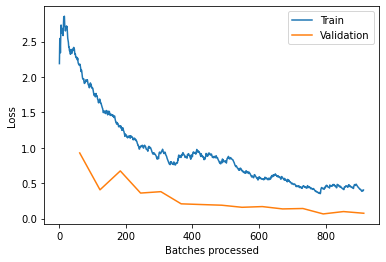

In [73]:
learn.recorder.plot_losses()

In [74]:
# Get the predictions for validation set and store as numpy array
preds = learn.get_preds()[0].argmax(dim=-1).numpy()
test_actual = learn.get_preds()[1].numpy()

# Get the predictions for training set and store as numpy array
train_pred = learn.get_preds(ds_type=DatasetType.Train)[0].argmax(dim=-1).numpy()
train_actual = learn.get_preds(ds_type=DatasetType.Train)[1].numpy()

# Calculate accuracy_score and append to Dataframe
val_acc = accuracy_score(test_actual, preds)
train_acc = accuracy_score(train_actual, train_pred)



In [75]:
val_acc, train_acc

(0.9754601226993865, 0.45081967213114754)

In [76]:
train_pred.shape, train_actual.shape

((244,), (244,))

In [77]:
preds.shape, test_actual.shape

((163,), (163,))

In [78]:
confusion_matrix(test_actual, preds)

array([[110,   0,   0,   0],
       [  0,   8,   0,   0],
       [  2,   0,  33,   0],
       [  2,   0,   0,   8]], dtype=int64)

In [79]:
confusion_matrix(train_actual, train_pred)

array([[99,  9, 37, 13],
       [ 9,  0,  1,  2],
       [36,  2, 10,  4],
       [16,  0,  5,  1]], dtype=int64)

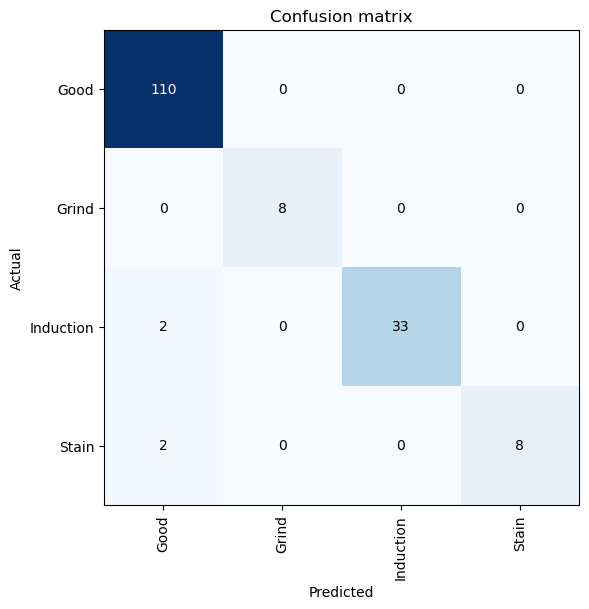

In [80]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)

In [81]:
learn.export(r"C:\Users\Desktop\Data\mobilenetv2_Callbacks_Albumentation.pkl")
#learn.save(os.path.join(model_save_path,'/resnet34_nocrk6000_epc2_stage-2'))

learn.save(r'C:\Users\Desktop\Data\mobilenetv2_Callbacks_Albumentation')

### Testing on New Images

In [ ]:
learn.load(r'C:\Users\Desktop\Data\mobilenetv2_Callbacks_Albumentation')

In [84]:
# predicting on a separate set, with labeled data
# use this method if there are several folders withing test folder
test_directory = r'C:\Users\Desktop\Data\Test'
images = []

for r, d, f in os.walk(test_directory):
    for file in f:
        #if file.endswith(".docx"):
        images.append(os.path.join(r, file))


In [ ]:
from fastai.vision import image
pred = []

for i in images:
    #img = image.open_image(test_directory+i)   # NameError: name 'image' is not defined  if image is not imported
    img = image.open_image(i)
    pred_class,pred_idx,outputs = learn.predict(img)
    pred.append(str(pred_class))

In [87]:
actual = []

for item in images:   # can be used if images are in sub-folders within test
#for item in os.listdir(test_directory):  # only when images are directly in "test"
    if 'Grind' in item:
        actual.append('Grind')
    if 'Induction' in item:
        actual.append('Induction')
    if 'Rust' in item:
        actual.append('Stain')
    if 'GOOD' in item:
        actual.append('Good')          

In [88]:
actual

['Grind',
 'Grind',
 'Induction',
 'Induction',
 'Induction',
 'Stain',
 'Stain',
 'Stain',
 'Good',
 'Good',
 'Good',
 'Good']

In [89]:
pred

['Grind',
 'Grind',
 'Induction',
 'Induction',
 'Grind',
 'Stain',
 'Stain',
 'Grind',
 'Good',
 'Good',
 'Good',
 'Good']

In [90]:
Test_Results={}

In [91]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

class_names = ['Good', 'Grind', 'Induction', 'Stain']
report=classification_report(actual, pred, target_names=class_names)
Classifiaction_Report=classification_report(actual, pred, target_names=class_names)
Test_Results["Classification Report"]=Classifiaction_Report

In [92]:
print(Classifiaction_Report)

              precision    recall  f1-score   support

        Good       1.00      1.00      1.00         4
       Grind       0.50      1.00      0.67         2
   Induction       1.00      0.67      0.80         3
       Stain       1.00      0.67      0.80         3

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.82        12
weighted avg       0.92      0.83      0.84        12



# Mobile Net -One call back

In [16]:
# Initialize cnn_learner object with the right model and its pretrained weights
learn = cnn_learner(data, mobilenet_v2, pretrained=True, metrics=metrics, cut=-1)

learn.loss_func = torch.nn.functional.cross_entropy
# learn.loss_func = nn.CrossEntropyLoss(weight=class_weights)

callbacks = [EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.01, patience=3)]
learn.callbacks = callbacks

# Progressive Learning

In [12]:
precision = Precision()
recall = Recall()
metrics = [accuracy,precision,recall]

In [ ]:
## load data
# fastai is automatically supposed to handle image format conversions- greyscale(L), RGB

# https://forums.fast.ai/t/how-to-load-images-as-grayscale/36895/6
# google: can fastai convert greyscale images to RGB

data_256 = ImageDataBunch.from_folder(image_path, 
                                  valid_pct=0.4,
                                  ds_tfms=get_transforms(), 
                                  size=256, 
                                  bs=bs, 
                                  num_workers=1,
                                  seed=9).normalize(imagenet_stats)

data_512 = ImageDataBunch.from_folder(image_path, 
                                  valid_pct=0.4,
                                  ds_tfms=get_transforms(), 
                                  size=512, 
                                  bs=bs, 
                                  num_workers=1,
                                  seed=9).normalize(imagenet_stats)

In [14]:
print(data_256.classes)
print(data_256.c)
print(len(data_256.train_ds))
print(len(data_256.valid_ds))


print(data_512.classes)
print(data_512.c)
print(len(data_512.train_ds))
print(len(data_512.valid_ds))

['Good', 'Grind', 'Induction', 'Stain']
4
167
110
['Good', 'Grind', 'Induction', 'Stain']
4
167
110


In [16]:
# count no. of examples in train & validation sets 
# train set
vc = pd.value_counts(data_256.train_ds.y.items, sort =False)
vc.index = data_256.classes
vc
# ratio

Good         101
Grind         12
Induction     39
Stain         15
dtype: int64

In [17]:
# val set
vc = pd.value_counts(data_256.valid_ds.y.items, sort=False)
# vc.index = data.classes
vc
# ratio

0    79
1     3
2    19
3     9
dtype: int64

In [18]:
# Initialize cnn_learner object with the right model and its pretrained weights
learn = cnn_learner(data_256, mobilenet_v2, pretrained=True, metrics=metrics, cut=-1,callback_fns=[partial(CSVLogger)])


#learn.loss_func = torch.nn.functional.cross_entropy
learn.loss_func = nn.CrossEntropyLoss()
#cb=CSVLogger(learn)


#Early Stopping Callback (learn, monitor='accuracy', min_delta=0.01, patience=3),
callbacks = [EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.01, patience=3),
             SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='Mobile_Net')]
learn.callbacks = callbacks

In [13]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [ ]:
#learn.fit_one_cycle(15,max_lr=slice(1.0E-06,1.0E-05), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name = model_save_name)]) 
epochs = 10
#max_lr=slice(1.0E-06,1.0E-05)
learn.fit_one_cycle(5)

In [20]:
# to free up cuda memory
torch.cuda.empty_cache()

In [21]:
learn.data = data_512 #loading the high res images
learn.unfreeze() #unfreezing the inital layers

In [ ]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [22]:
epochs = 5
#max_lr=slice(1.0E-06,1.0E-05)
learn.fit_one_cycle(epochs)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.203707,0.256814,0.918182,0.889373,0.866959,01:19
1,1.252960,2.727787,0.427273,0.672165,0.393645,01:18
2,1.226562,0.139408,0.972727,0.896875,0.945906,01:16
3,0.941103,0.152425,0.963636,0.857143,0.942742,01:16
4,0.874119,0.150776,0.963636,0.857143,0.942742,01:19


Better model found at epoch 0 with valid_loss value: 0.25681379437446594.
Better model found at epoch 2 with valid_loss value: 0.13940773904323578.


In [23]:
learn.export(r"C:\Users\Desktop\Data\mobilenetv2_Callbacks_Progressive_5epochs.pkl")
#learn.save(os.path.join(model_save_path,'/resnet34_nocrk6000_epc2_stage-2'))

learn.save(r'C:\Users\Desktop\Data\mobilenetv2_Callbacks_Progressive_5epochs')

In [ ]:
learn.load(r'C:\Users\Desktop\Data\mobilenetv2_Callbacks_Progressive_5epochs')

In [25]:
# predicting on a separate set, with labeled data
# use this method if there are several folders withing test test_directory = r'C:\Users\NEI3KoR\Desktop\Hemanth\Projects\VQI-Accelerator\Classification Codes\data\IMAGES\test'
test_directory = r'C:\Users\Desktop\Data\Test'
images = []

for r, d, f in os.walk(test_directory):
    for file in f:
        #if file.endswith(".docx"):
        images.append(os.path.join(r, file))


In [ ]:
from fastai.vision import image
pred = []

for i in images:
    #img = image.open_image(test_directory+i)   # NameError: name 'image' is not defined  if image is not imported
    img = image.open_image(i)
    pred_class,pred_idx,outputs = learn.predict(img)
    pred.append(str(pred_class))

In [27]:
actual = []

for item in images:   # can be used if images are in sub-folders within test
#for item in os.listdir(test_directory):  # only when images are directly in "test"
    if 'Grind' in item:
        actual.append('Grind')
    if 'Induction' in item:
        actual.append('Induction')
    if 'Rust' in item:
        actual.append('Stain')
    if 'GOOD' in item:
        actual.append('Good')          

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
Test_Results={}
class_names = ['Good', 'Grind', 'Induction', 'Stain']
report=classification_report(actual, pred, target_names=class_names)
Classifiaction_Report=classification_report(actual, pred, target_names=class_names)
Test_Results["Classification Report"]=Classifiaction_Report

In [29]:
print(Classifiaction_Report)

              precision    recall  f1-score   support

        Good       1.00      1.00      1.00         4
       Grind       0.00      0.00      0.00         2
   Induction       1.00      0.67      0.80         3
       Stain       0.50      1.00      0.67         3

    accuracy                           0.75        12
   macro avg       0.62      0.67      0.62        12
weighted avg       0.71      0.75      0.70        12



# Albumentaion

In [2]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A

In [25]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)
   

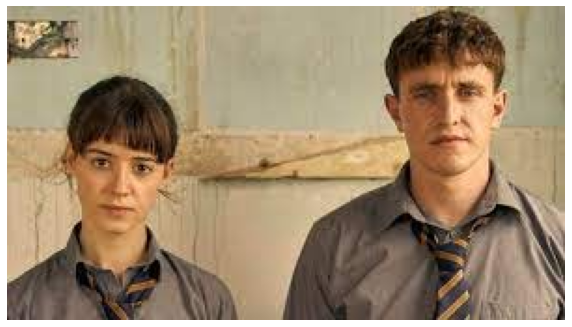

In [26]:
Original_image = cv2.imread('people.jpg')
image = cv2.cvtColor(Original_image, cv2.COLOR_BGR2RGB)
visualize(image)

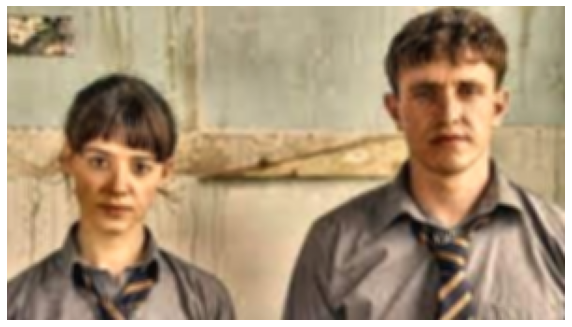

In [27]:
transform = A.Compose([
    A.CLAHE(),
    A.RandomRotate90(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
    A.Blur(blur_limit=3),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
])
random.seed(42) 
augmented_image = transform(image=image)['image']
visualize(augmented_image)

In [30]:
cv2.imwrite("sample.png",augmented_image)

True

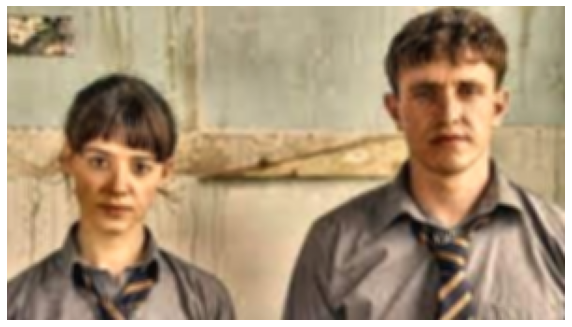

In [31]:
# to read the augmented image
visualize(cv2.imread("sample.png"))

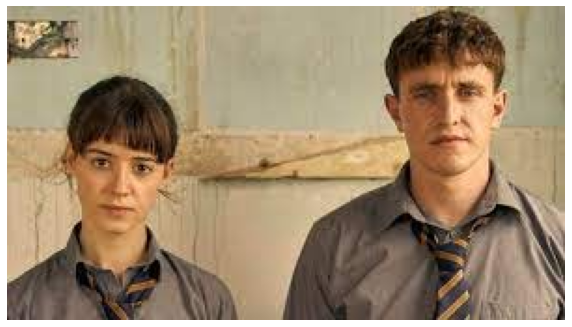

In [35]:
i=cv2.imread("people.jpg")
image = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
visualize(image)

In [58]:
file_dir=r'C:\Users\Desktop\Data\class1'
output_path = r'C:\Users\Desktop\Data\class1'

In [ ]:
for root, _, files in os.walk(file_dir):
    print("Root",root)
    for file in files:
        name_int = file[:len(file)-4]
        Name=root+"\\"+file
        Original_image = cv2.imread(Name)
        image = cv2.cvtColor(Original_image, cv2.COLOR_BGR2RGB)
        transform = A.Compose([
        A.CLAHE(),
        A.RandomRotate90(),
        A.Transpose(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
        A.Blur(blur_limit=3),
        A.OpticalDistortion(),
        A.GridDistortion(),
        A.HueSaturationValue(),])
        random.seed(42) 
        augmented_image = transform(image=image)['image']
        cv2.imwrite(output_path+"\\"+'%s' %str(name_int)+'_Albumentation.jpg', augmented_image)

# Albumentation Object Detection

In [110]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

### VGG16

In [ ]:
learn1 = cnn_learner(data, vgg16, pretrained=True, metrics=metrics)
# Below is needed since you get negative loss otherwise Ref: https://forums.fast.ai/t/negative-loss-with-letters-mnist/30889/15
# learn.loss_func = torch.nn.functional.cross_entropy
learn1.loss_func = nn.CrossEntropyLoss(weight=class_weights)

callbacks = [EarlyStoppingCallback(learn1, monitor='accuracy', min_delta=0.01, patience=3), 
             SaveModelCallback(learn1, every='improvement', monitor='accuracy')]
learn1.callbacks = callbacks

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


By default, only the fully connected layers at the top are unfrozen (can be trained) (only in Fastai not Pytorch) ((i.e. requires_grad=False for all layers except FCN)

In [ ]:
learn1.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.319911,1.910482,0.103448,nan,0.321429,00:10
1,1.958246,1.237220,0.517241,nan,0.287594,00:03
2,1.551973,1.266010,0.551724,0.460714,0.604323,00:03
3,1.320657,1.307225,0.586207,0.658333,0.617481,00:03
4,1.090372,1.330631,0.586207,0.628125,0.706767,00:03
5,0.905562,1.332464,0.586207,nan,0.380639,00:03
6,0.773023,1.378348,0.586207,nan,0.380639,00:03


Better model found at epoch 0 with accuracy value: 0.1034482792019844.
Better model found at epoch 1 with accuracy value: 0.517241358757019.
Better model found at epoch 2 with accuracy value: 0.5517241358757019.
Better model found at epoch 3 with accuracy value: 0.5862069129943848.
Epoch 7: early stopping


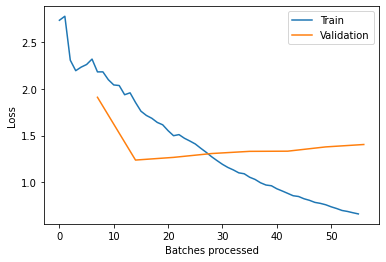

In [ ]:
learn1.recorder.plot_losses()

In [ ]:
# Get the predictions for validation set and store as numpy array
preds = learn1.get_preds()[0].argmax(dim=-1).numpy()
test_actual = learn1.get_preds()[1].numpy()

# Get the predictions for training set and store as numpy array
train_pred = learn1.get_preds(ds_type=DatasetType.Train)[0].argmax(dim=-1).numpy()
train_actual = learn1.get_preds(ds_type=DatasetType.Train)[1].numpy()

# Calculate accuracy_score and append to Dataframe
val_acc = accuracy_score(test_actual, preds)
train_acc = accuracy_score(train_actual, train_pred)

In [ ]:
val_acc, train_acc

(0.5862068965517241, 0.45535714285714285)

In [ ]:
confusion_matrix(test_actual, preds)

array([[13,  0,  0,  6],
       [ 0,  1,  0,  0],
       [ 2,  0,  2,  3],
       [ 0,  0,  1,  1]])

In [ ]:
confusion_matrix(train_actual, train_pred)

array([[43,  5, 15, 11],
       [ 3,  0,  1,  1],
       [13,  1,  7,  3],
       [ 4,  1,  3,  1]])

### ResNet50

In [ ]:
learn2 = cnn_learner(data, resnet50, pretrained=True, metrics=metrics)
learn2.loss_func = torch.nn.functional.cross_entropy

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


By default, only the fully connected layers at the top are unfrozen (can be trained) (only in Fastai not Pytorch) ((i.e. requires_grad=False for all layers except FCN)

In [ ]:
learn2.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.541088,1.394131,0.586207,nan,0.223684,00:08
1,2.066768,1.742163,0.482759,nan,0.421053,00:04
2,1.687377,1.428046,0.413793,nan,0.439850,00:04
3,1.333429,1.770467,0.310345,nan,0.163534,00:04
4,1.149831,1.601366,0.448276,0.320833,0.453008,00:04
5,0.954081,1.203817,0.689655,0.434722,0.567669,00:04
6,0.795043,1.015514,0.724138,0.750000,0.692669,00:04
7,0.664323,0.898260,0.620690,nan,0.281955,00:04
8,0.586723,0.944132,0.689655,nan,0.330827,00:04
9,0.507827,0.816107,0.689655,0.462500,0.420113,00:04


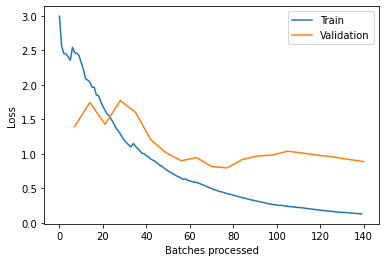

In [ ]:
learn2.recorder.plot_losses()

In [ ]:
# # Let's find the best learning rate
# learn2.unfreeze()
# learn2.lr_find()
# # Plot the learning rate
# learn2.recorder.plot()

In [ ]:
# learn.unfreeze()
# #learn.fit_one_cycle(4)
# learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

In [ ]:
# preds,y = learn2.get_preds()
# interp = ClassificationInterpretation.from_learner(learn2)
# interp.plot_confusion_matrix()  # wrong predictions for crack reduce at the cost of no crack

interp

In [ ]:
# Get the predictions for validation set and store as numpy array
preds = learn2.get_preds()[0].argmax(dim=-1).numpy()
test_actual = learn2.get_preds()[1].numpy()

# Get the predictions for training set and store as numpy array
train_pred = learn2.get_preds(ds_type=DatasetType.Train)[0].argmax(dim=-1).numpy()
train_actual = learn2.get_preds(ds_type=DatasetType.Train)[1].numpy()

# Calculate accuracy_score and append to Dataframe
val_acc = accuracy_score(test_actual, preds)
train_acc = accuracy_score(train_actual, train_pred)

In [ ]:
val_acc, train_acc

(0.7241379310344828, 0.5535714285714286)

In [ ]:
confusion_matrix(test_actual, preds)

array([[18,  1,  0,  0],
       [ 0,  0,  1,  0],
       [ 3,  1,  3,  0],
       [ 0,  0,  2,  0]])

In [ ]:
confusion_matrix(train_actual, train_pred)

array([[52,  1, 16,  4],
       [ 2,  1,  1,  1],
       [13,  3,  7,  2],
       [ 5,  1,  1,  2]])

# Data Augmentation

In [ ]:
import os

os.listdir(r"C:\Users\Desktop\Data\Data_Augmentation")

In [181]:
file_dir=r'C:\Users\Desktop\Data\class2'
output_path = r'C:\Users\Desktop\Data\class2'

In [179]:
# New Function
import os
def Augmentation(file_dir,output_path):
    for root, _, files in os.walk(file_dir):
        print(root)
    for file in files:
        name_int = file[:len(file)-4]
        Name=root+"\\"+file
        image = cv2.imread(Name)
        w = image.shape[1]
        h = image.shape[0]
        
#         #rotate matrix
#         M = cv2.getRotationMatrix2D((w/2,h/2), 90, 1)
#         #rotate
#         Rotation_image = cv2.warpAffine(image,M,(w,h))
#         cv2.imwrite(output_path+"\\"+'%s' %str(name_int)+'_rotation.jpg', Rotation_image)
        
#         #Flipping the images Vertically
#         vflip=True
#         hflip=False
#         if hflip or vflip:
#             if hflip and vflip:
#                 c = -1
#             else:
#                 c = 0 if vflip else 1
#             Flipped_image = cv2.flip(image, flipCode=c)
#         cv2.imwrite(output_path+"\\"+'%s' %str(name_int)+'_vflip.jpg', Flipped_image)
        
#         #Flipping the images Horizontally
#         vflip=False
#         hflip=True
#         if hflip or vflip:
#             if hflip and vflip:
#                 c = -1
#             else:
#                 c = 0 if vflip else 1
#             Flipped_image = cv2.flip(image, flipCode=c)
#         cv2.imwrite(output_path+"\\"+'%s' %str(name_int)+'_hflip.jpg', Flipped_image)
        
        #Channel Shift
        value = int(random.uniform(-60, 60))
        img = image + value
        img[:,:,:][img[:,:,:]>255]  = 255
        img[:,:,:][img[:,:,:]<0]  = 0
        Channel_Shift_img = img.astype(np.uint8)
        cv2.imwrite(output_path+"\\"+'%s' %str(name_int)+'_ChannelShift.jpg', Channel_Shift_img)
        
        #To increase the Brightness
        value = random.uniform(0.5, 3)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv = np.array(hsv, dtype = np.float64)
        hsv[:,:,1] = hsv[:,:,1]*value
        hsv[:,:,1][hsv[:,:,1]>255]  = 255
        hsv[:,:,2] = hsv[:,:,2]*value 
        hsv[:,:,2][hsv[:,:,2]>255]  = 255
        hsv = np.array(hsv, dtype = np.uint8)
        Brightness_Image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        cv2.imwrite(output_path+"\\"+'%s' %str(name_int)+'_Brightness.jpg', Channel_Shift_img)

       
        

In [ ]:
Augmentation(file_dir,output_path)

In [48]:
import cv2
import random
import numpy as np
img = cv2.imread('people.jpg')
def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img
img = brightness(img, 0.5, 3)
cv2.imshow('Result', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite("Sample_people.png",img)

113

True